# NOAA-21 NUCAPS Profile 1323 UTC 27 December 2023

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import h5py
from six import StringIO

'''
NOAA-21 NUCAPS Profile at 1323 UTC 27 December 2023 50.3N/5.1W
'''

def read_nprovs_names(ncf):
    nc_fid = Dataset(ncf, 'r')
    names = nc_fid.variables.keys()
    nc_fid.close()
    return names

nprovs_ret_file = 'nprovs_20231227.nc'
names = read_nprovs_names(nprovs_ret_file)
print(names)

# Open file.
FILE_NAME = 'nprovs_20231227.nc'
temperature = '/20231227/NUCAPS_NOAA-21_609/microwave_temperature'
pressure = '/20231227/NUCAPS_NOAA-21_609/pressure'
humidity = '/20231227/NUCAPS_NOAA-21_609/microwave_relative_humidity'
LATITUDE = '/20231227/NUCAPS_NOAA-21_609/latitude'
LONGITUDE = '/20231227/NUCAPS_NOAA-21_609/longitude'
time = '/20231227/NUCAPS_NOAA-21_609/time'

with h5py.File(FILE_NAME, mode='r') as f:
    # List available datasets.
    print(f.keys())

    # Read dataset.
    temp = f[temperature]
    temp_ret = temp[:,:]
    print("Temp: ",temp_ret,temp_ret.shape)
    press = f[pressure]
    press_ret = press[:,:]
    print("Press: ",press_ret,press_ret.shape)
    RH = f[humidity]
    RH_ret = RH[:,:]
    print("Humidity: ",RH_ret,RH_ret.shape)
    latitude = f[LATITUDE]
    lat = latitude[685]
    print("Latitude: ",lat)
    longitude = f[LONGITUDE]
    lon = longitude[685]
    print("Longitude: ",lon)
    time = f[time]
    time_ret = time[685]
    print("Time: ",time_ret)

print("Pressure: ",press_ret,press_ret.shape)
press = press_ret[685,43:96]
print("Pressure retrieval: ",press,press.shape)
press = press[::-1]
print("Pressure: ",press,press.shape)

print("Temperature: ",temp_ret,temp_ret.shape)
temp = temp_ret[685,43:96]
print("Temperature retrieval: ",temp,temp.shape)
temp = temp[::-1]
print("Temperature: ",temp,temp.shape)

print("Humidity: ", RH_ret)
RH = RH_ret[685,43:96]
print("Humidity retrieval: ",RH,RH.shape)
RH_pct = RH[::-1]
print("Humidity: ",RH_pct,RH_pct.shape)
temperature_c = temp - 273.15
dewpoint_c = 243.04*((np.log(RH_pct/100))+((17.625*temperature_c)/(243.04+temperature_c)))/(17.625-(np.log(RH_pct/100))-((17.625*temperature_c)/(243.04+temperature_c)))
dewpoint = dewpoint_c + 273.15
print(dewpoint,dewpoint.shape)
height_km = np.array([0.2,0.5,0.7,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.2,3.5,3.7,4.0,4.25,4.5,4.8,5.0,5.5,5.7,6.0,
                      6.2,6.5,6.75,7.0,7.5,7.7,8.0,8.25,8.5,8.8,9.0,9.5,9.8,10.0,10.5,10.75,11.0,11.5,11.75,12.0,12.5,
                      13.0,13.25,13.5,14.0,14.5,15.0,15.25,15.5,16.0])
height_m = height_km * 1000
print(height_m,len(height_m))
height_km = height_m/1000
print(height_km,len(height_km))
pressure_pa = press

L_vapor = 2500

thetae = (273.15 + temperature_c)*((1000/pressure_pa)**0.286)+(3 * (RH_pct * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
print("Theta-e: ", thetae, thetae.shape)
wetbulb = temperature_c*(np.arctan(0.151977*((RH_pct+8.313659)**0.5))) + (np.arctan(temperature_c+RH_pct)) - (np.arctan(RH_pct-1.676331))+((0.00391838*(RH_pct**1.5))*(np.arctan(0.023101*RH_pct))) - 4.686035
print("Wet bulb: ", wetbulb, wetbulb.shape)
WBD = temperature_c - wetbulb
satmixrat = (6.11*(10**((7.5*temperature_c)/(237.7+temperature_c))))/1000
print("Sat_mix_ratio = ",satmixrat)
mixrat = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/1000
print("Mix_ratio = ",mixrat)
thetaw = thetae - (L_vapor*mixrat)
tempvirt = temp*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c

idx_pup = np.where(press == 852.8)
idx_plo = np.where(press == 986.1)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temp[idx_plo]
T_top = temp[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
thetaw_sfc = thetaw[idx_pup]
delta_z = 1300
delta_zkm = 1.3
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    
 
mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_pa,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = -9999.00
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_pa, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

P_level_upper = pressure_pa[idx_pup]
P_level_lower = pressure_pa[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 0

print("Dry bulb temperature calculation")
print("")
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        return MWPI, WGP
MWPI, WGP = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)
print("")
print("Virtual temperature calculation")
print("")
def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = Tv_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = Tv_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import h5py
from six import StringIO

'''
NOAA-21 NUCAPS Profile at 1323 UTC 27 December 2023 50.3N/5.1W
'''

def read_nprovs_names(ncf):
    nc_fid = Dataset(ncf, 'r')
    names = nc_fid.variables.keys()
    nc_fid.close()
    return names

nprovs_ret_file = 'nprovs_20231227.nc'
names = read_nprovs_names(nprovs_ret_file)
print(names)

# Open file.
FILE_NAME = 'nprovs_20231227.nc'
temperature = '/20231227/NUCAPS_NOAA-21_609/temperature'
pressure = '/20231227/NUCAPS_NOAA-21_609/pressure'
humidity = '/20231227/NUCAPS_NOAA-21_609/relative_humidity'
LATITUDE = '/20231227/NUCAPS_NOAA-21_609/latitude'
LONGITUDE = '/20231227/NUCAPS_NOAA-21_609/longitude'
time = '/20231227/NUCAPS_NOAA-21_609/time'

with h5py.File(FILE_NAME, mode='r') as f:
    # List available datasets.
    print(f.keys())

    # Read dataset.
    temp = f[temperature]
    temp_ret = temp[:,:]
    print("Temp: ",temp_ret,temp_ret.shape)
    press = f[pressure]
    press_ret = press[:,:]
    print("Press: ",press_ret,press_ret.shape)
    RH = f[humidity]
    RH_ret = RH[:,:]
    print("Humidity: ",RH_ret,RH_ret.shape)
    latitude = f[LATITUDE]
    lat = latitude[685]
    print("Latitude: ",lat)
    longitude = f[LONGITUDE]
    lon = longitude[685]
    print("Longitude: ",lon)
    time = f[time]
    time_ret = time[685]
    print("Time: ",time_ret)

print("Pressure: ",press_ret,press_ret.shape)
press = press_ret[685,43:96]
print("Pressure retrieval: ",press,press.shape)
press = press[::-1]
print("Pressure: ",press,press.shape)

print("Temperature: ",temp_ret,temp_ret.shape)
temp = temp_ret[685,43:96]
print("Temperature retrieval: ",temp,temp.shape)
temp = temp[::-1]
print("Temperature: ",temp,temp.shape)

print("Humidity: ", RH_ret)
RH = RH_ret[685,43:96]
print("Humidity retrieval: ",RH,RH.shape)
RH_pct = RH[::-1]
print("Humidity: ",RH_pct,RH_pct.shape)
temperature_c = temp - 273.15
dewpoint_c = 243.04*((np.log(RH_pct/100))+((17.625*temperature_c)/(243.04+temperature_c)))/(17.625-(np.log(RH_pct/100))-((17.625*temperature_c)/(243.04+temperature_c)))
dewpoint = dewpoint_c + 273.15
print(dewpoint,dewpoint.shape)
height_km = np.array([0.2,0.5,0.7,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.2,3.5,3.7,4.0,4.25,4.5,4.8,5.0,5.5,5.7,6.0,
                      6.2,6.5,6.75,7.0,7.5,7.7,8.0,8.25,8.5,8.8,9.0,9.5,9.8,10.0,10.5,10.75,11.0,11.5,11.75,12.0,12.5,
                      13.0,13.25,13.5,14.0,14.5,15.0,15.25,15.5,16.0])
height_m = height_km * 1000
print(height_m,len(height_m))
height_km = height_m/1000
print(height_km,len(height_km))
pressure_pa = press

L_vapor = 2500

thetae = (273.15 + temperature_c)*((1000/pressure_pa)**0.286)+(3 * (RH_pct * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
print("Theta-e: ", thetae, thetae.shape)
wetbulb = temperature_c*(np.arctan(0.151977*((RH_pct+8.313659)**0.5))) + (np.arctan(temperature_c+RH_pct)) - (np.arctan(RH_pct-1.676331))+((0.00391838*(RH_pct**1.5))*(np.arctan(0.023101*RH_pct))) - 4.686035
print("Wet bulb: ", wetbulb, wetbulb.shape)
WBD = temperature_c - wetbulb
satmixrat = (6.11*(10**((7.5*temperature_c)/(237.7+temperature_c))))/1000
print("Sat_mix_ratio = ",satmixrat)
mixrat = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/1000
print("Mix_ratio = ",mixrat)
thetaw = thetae - (L_vapor*mixrat)
tempvirt = temp*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c

idx_pup = np.where(press == 852.8)
idx_plo = np.where(press == 986.1)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temp[idx_plo]
T_top = temp[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
thetaw_sfc = thetaw[idx_pup]
delta_z = 1300
delta_zkm = 1.3
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    
 
mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_pa,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = -9999.00
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_pa, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

P_level_upper = pressure_pa[idx_pup]
P_level_lower = pressure_pa[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 0

print("Dry bulb temperature calculation")
print("")
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        return MWPI, WGP
MWPI, WGP = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)
print("")
print("Virtual temperature calculation")
print("")
def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = Tv_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = Tv_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from six import StringIO
import pandas as pd

'''
03808 Camborne RAOB Profile at 1200 UTC 27 December 2023 
'''

data_txt = '''
  988.0     88   12.0   11.5     97   8.69    200     27  286.1  310.5  287.6
  974.0    207   11.3   10.5     95   8.23    200     41  286.6  309.7  288.0
  969.0    250   11.0   10.1     94   8.07    202     47  286.7  309.4  288.1
  959.0    337   10.6    9.8     95   7.97    205     59  287.1  309.6  288.5
  942.0    486    9.8    9.2     96   7.81    205     64  287.8  309.9  289.2
  941.0    495    9.8    9.5     98   7.98    205     64  287.9  310.5  289.3
  940.0    503    9.8    9.8    100   8.15    205     64  288.0  311.1  289.4
  925.0    637    9.0    9.0    100   7.84    210     63  288.5  310.8  289.9
  891.0    946    7.3    7.2     99   7.20    215     56  289.9  310.5  291.1
  880.0   1049    6.8    6.6     99   6.99    215     62  290.3  310.4  291.6
  869.0   1153    6.2    6.0     99   6.79    220     58  290.8  310.4  292.0
  868.0   1162    6.2    5.8     98   6.72    220     58  290.9  310.2  292.0
  855.0   1286    5.8    3.6     86   5.83    220     59  291.7  308.7  292.8
  850.0   1334    5.4    3.5     88   5.82    220     60  291.8  308.8  292.8
  826.0   1568    3.8    3.8    100   6.12    220     65  292.5  310.4  293.6
  807.0   1756    2.6    2.6    100   5.73    220     69  293.1  309.9  294.1
  795.0   1878    1.8    1.8    100   5.49    225     64  293.5  309.7  294.5
  778.0   2053    0.6    0.6    100   5.16    223     70  294.1  309.4  295.0
  760.0   2240   -0.2   -0.2    100   5.00    220     76  295.2  310.1  296.1
  730.0   2562   -1.5   -1.5    100   4.72    225     72  297.2  311.4  298.0
  700.0   2897   -2.9   -2.9    100   4.43    225     76  299.2  312.8  300.1
  696.0   2942   -2.9   -3.1     99   4.39    226     76  299.7  313.2  300.5
  685.0   3069   -3.7   -3.7    100   4.27    229     74  300.2  313.3  301.0
  681.0   3115   -4.0   -4.2     99   4.14    230     74  300.4  313.1  301.1
  669.0   3255   -5.0   -5.7     95   3.77    235     81  300.8  312.4  301.4
  647.0   3518   -6.9   -8.4     89   3.15    235     84  301.5  311.4  302.1
  641.0   3590   -7.5   -8.6     92   3.13    235     85  301.6  311.4  302.2
  637.0   3639   -7.8   -9.3     89   2.97    235     86  301.8  311.2  302.4
  633.0   3688   -8.1  -10.1     86   2.82    236     86  302.0  310.9  302.6
  613.0   3937   -9.9  -11.6     88   2.59    240     87  302.7  311.0  303.2
  611.0   3962  -10.1  -11.7     88   2.57    239     87  302.8  311.0  303.3
  598.0   4128  -10.3  -11.3     92   2.71    230     86  304.4  313.1  304.9
  581.0   4350  -11.3  -11.8     96   2.68    224     82  305.8  314.4  306.3
  572.0   4469  -12.0  -12.7     95   2.54    220     80  306.4  314.6  306.9
  565.0   4563  -12.5  -13.3     93   2.43    225     85  306.8  314.7  307.3
  556.0   4685  -13.2  -14.2     92   2.30    220     77  307.4  314.9  307.9
  546.0   4824  -14.0  -15.2     90   2.15    220     81  308.1  315.2  308.5
  538.0   4936  -14.6  -16.1     89   2.04    225     76  308.6  315.4  309.0
  527.0   5094  -15.5  -17.2     87   1.89    220     83  309.4  315.7  309.8
  517.0   5238  -15.9  -17.7     86   1.85    220     74  310.6  316.8  310.9
  500.0   5490  -16.7  -18.6     85   1.77    215     85  312.6  318.6  312.9
  492.0   5611  -16.9  -18.8     85   1.77    215     95  313.8  319.8  314.1
  478.0   5823  -18.4  -20.2     86   1.61    215     97  314.5  320.0  314.8
  470.0   5947  -19.3  -21.1     86   1.52    215     92  314.9  320.1  315.2
  460.0   6104  -20.5  -22.2     86   1.41    210     98  315.4  320.3  315.7
  443.0   6381  -22.5  -24.1     87   1.24    215     93  316.3  320.7  316.6
  433.0   6548  -23.7  -25.2     87   1.14    215    100  316.9  320.9  317.1
  427.0   6651  -24.4  -25.9     87   1.09    215     97  317.2  321.0  317.4
  400.0   7130  -27.9  -29.2     89   0.86    215    102  318.6  321.7  318.8
  398.0   7166  -28.1  -29.2     90   0.86    215    102  318.8  321.9  319.0
  364.0   7799  -32.8  -35.1     79   0.53    215    104  320.8  322.8  320.9
  355.0   7976  -34.1  -36.8     76   0.46    215    109  321.4  323.1  321.4
  350.0   8075  -34.9  -37.8     75   0.42    215    112  321.5  323.1  321.6
  335.0   8379  -37.5  -41.0     70   0.32    217    110  322.1  323.3  322.1
  312.0   8866  -41.7  -44.8     72   0.23    220    106  322.8  323.7  322.9
  311.0   8887  -41.9  -45.0     72   0.22    220    106  322.9  323.7  322.9
  309.0   8931  -42.5  -45.1     76   0.22    220    107  322.6  323.5  322.6
  300.0   9130  -44.1  -47.1     72   0.18    220    111  323.1  323.8  323.1
  295.0   9242  -44.9  -48.1     70   0.17    220    112  323.5  324.2  323.5
  284.0   9494  -47.3  -49.8     75   0.14    220    115  323.6  324.2  323.6
  278.0   9634  -48.7  -51.9     69   0.11    220    116  323.6  324.0  323.6
  274.0   9729  -49.5  -53.9     60   0.09    220    117  323.8  324.1  323.8
  270.0   9825  -50.3  -53.7     67   0.10    220    118  323.9  324.4  324.0
  268.0   9873  -50.7  -54.8     62   0.08    220    118  324.1  324.4  324.1
  261.0  10044  -52.1  -56.5     59   0.07    220    120  324.5  324.8  324.5
  260.0  10069  -52.5  -56.8     60   0.07    220    120  324.2  324.5  324.2
  258.0  10119  -52.9  -57.9     54   0.06    220    121  324.4  324.6  324.4
  256.0  10168  -53.3  -56.8     65   0.07    221    121  324.5  324.8  324.5
  255.0  10194  -53.7  -58.2     58   0.06    222    120  324.3  324.5  324.3
  253.0  10244  -54.1  -58.5     58   0.06    223    120  324.4  324.6  324.4
  250.0  10320  -54.9  -60.9     47   0.04    225    119  324.3  324.5  324.3
  249.0  10346  -55.1  -61.1     47   0.04    225    119  324.4  324.6  324.4
  238.0  10634  -57.9  -62.5     55   0.04    226    123  324.4  324.5  324.4
  234.0  10741  -58.9  -63.9     52   0.03    227    125  324.4  324.6  324.4
  229.0  10876  -60.1  -64.6     55   0.03    227    127  324.6  324.8  324.6
  225.0  10986  -61.1  -66.1     51   0.02    227    128  324.7  324.8  324.7
  224.0  11014  -61.3  -67.3     45   0.02    228    129  324.8  324.9  324.9
  218.0  11183  -62.9  -67.3     55   0.02    228    131  324.9  325.0  324.9
  212.0  11355  -64.3  -69.1     52   0.02    229    133  325.3  325.4  325.3
  202.0  11650  -66.7  -70.6     58   0.01    230    138  326.1  326.1  326.1
  201.0  11680  -67.0  -71.0     57   0.01    230    138  326.0  326.1  326.0
  200.0  11710  -67.3  -71.4     56   0.01    230    138  326.0  326.1  326.0
  195.0  11862  -68.7  -73.2     52   0.01    230    129  326.2  326.2  326.2
  192.0  11954  -69.5  -73.8     53   0.01    230    124  326.3  326.4  326.3
  188.0  12079  -70.3  -73.6     62   0.01    230    117  327.0  327.1  327.0
  186.0  12143  -68.7  -72.9     55   0.01    227    112  330.6  330.6  330.6
  184.0  12207  -67.5  -73.5     42   0.01    224    107  333.6  333.6  333.6
  182.0  12273  -66.9  -74.9     31   0.01    221    102  335.6  335.6  335.6
  181.0  12306  -66.7  -75.7     27   0.01    220     99  336.4  336.5  336.4
  180.0  12340  -66.5  -76.5     23   0.01    220    100  337.3  337.3  337.3
  171.0  12648  -67.9  -77.9     23   0.01    225    109  340.0  340.0  340.0
  170.0  12684  -67.7  -78.5     20   0.01    225    110  340.9  340.9  340.9
  165.0  12863  -66.5  -81.5     11   0.00    229    108  345.8  345.8  345.8
  159.0  13087  -65.5  -82.5      8   0.00    233    106  351.2  351.2  351.2
  157.0  13164  -65.7  -82.5      8   0.00    235    105  352.1  352.1  352.1
  150.0  13440  -66.5  -82.5      9   0.00    240     91  355.3  355.4  355.3
  144.0  13690  -63.1  -83.1      5   0.00    242     82  365.4  365.4  365.4
  140.0  13863  -62.9  -83.9      4   0.00    243     76  368.7  368.7  368.7
  134.0  14130  -63.7  -84.3      5   0.00    245     67  372.0  372.0  372.0
  129.0  14361  -64.3  -84.6      5   0.00    250     74  374.9  374.9  374.9
  118.0  14903  -65.8  -85.3      5   0.00    245     61  381.8  381.8  381.8
  107.0  15498  -67.5  -86.1      6   0.00    240     67  389.4  389.4  389.4
  100.0  15910  -68.7  -86.7      6   0.00    250     71  394.7  394.7  394.7  
'''
raobprof = StringIO(data_txt)
pressure_mb,height,temperature_c,dewpoint_c,RH_pct,mixrat,wdir,wspd = np.loadtxt(raobprof, usecols=range(0, 8), unpack=True)

press = pressure_mb.tolist()
print("Pressure : ", press, len(press))
height_m = height.tolist()
print("Height : ", height_m, len(height_m))
 
data_sharppy=dict(zip(('pres','hght','temp','dwpt','wdir','wspd'),(pressure_mb, height, temperature_c, dewpoint_c, wdir, wspd)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt', 'wdir', 'wspd']]
print(df_sharppy)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

Pressure :  [988.0, 974.0, 969.0, 959.0, 942.0, 941.0, 940.0, 925.0, 891.0, 880.0, 869.0, 868.0, 855.0, 850.0, 826.0, 807.0, 795.0, 778.0, 760.0, 730.0, 700.0, 696.0, 685.0, 681.0, 669.0, 647.0, 641.0, 637.0, 633.0, 613.0, 611.0, 598.0, 581.0, 572.0, 565.0, 556.0, 546.0, 538.0, 527.0, 517.0, 500.0, 492.0, 478.0, 470.0, 460.0, 443.0, 433.0, 427.0, 400.0, 398.0, 364.0, 355.0, 350.0, 335.0, 312.0, 311.0, 309.0, 300.0, 295.0, 284.0, 278.0, 274.0, 270.0, 268.0, 261.0, 260.0, 258.0, 256.0, 255.0, 253.0, 250.0, 249.0, 238.0, 234.0, 229.0, 225.0, 224.0, 218.0, 212.0, 202.0, 201.0, 200.0, 195.0, 192.0, 188.0, 186.0, 184.0, 182.0, 181.0, 180.0, 171.0, 170.0, 165.0, 159.0, 157.0, 150.0, 144.0, 140.0, 134.0, 129.0, 118.0, 107.0, 100.0] 103
Height :  [88.0, 207.0, 250.0, 337.0, 486.0, 495.0, 503.0, 637.0, 946.0, 1049.0, 1153.0, 1162.0, 1286.0, 1334.0, 1568.0, 1756.0, 1878.0, 2053.0, 2240.0, 2562.0, 2897.0, 2942.0, 3069.0, 3115.0, 3255.0, 3518.0, 3590.0, 3639.0, 3688.0, 3937.0, 3962.0, 4128.0, 4350.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import h5py
from six import StringIO

'''
METOP-C NUCAPS MW Profile at 2211 UTC 27 December 2023 50.3N/6.5W
'''

def read_nprovs_names(ncf):
    nc_fid = Dataset(ncf, 'r')
    names = nc_fid.variables.keys()
    nc_fid.close()
    return names

nprovs_ret_file = 'nprovs_20231227.nc'
names = read_nprovs_names(nprovs_ret_file)
print(names)

# Open file.
FILE_NAME = 'nprovs_20231227.nc'
temperature = '/20231227/NUCAPS_MetOpC_608/microwave_temperature'
pressure = '/20231227/NUCAPS_MetOpC_608/pressure'
humidity = '/20231227/NUCAPS_MetOpC_608/microwave_relative_humidity'
LATITUDE = '/20231227/NUCAPS_MetOpC_608/latitude'
LONGITUDE = '/20231227/NUCAPS_MetOpC_608/longitude'
time = '/20231227/NUCAPS_MetOpC_608/time'

with h5py.File(FILE_NAME, mode='r') as f:
    # List available datasets.
    print(f.keys())

    # Read dataset.
    temp = f[temperature]
    temp_ret = temp[:,:]
    print("Temp: ",temp_ret,temp_ret.shape)
    press = f[pressure]
    press_ret = press[:,:]
    print("Press: ",press_ret,press_ret.shape)
    RH = f[humidity]
    RH_ret = RH[:,:]
    print("Humidity: ",RH_ret,RH_ret.shape)
    latitude = f[LATITUDE]
    lat = latitude[521]
    print("Latitude: ",lat)
    longitude = f[LONGITUDE]
    lon = longitude[521]
    print("Longitude: ",lon)
    time = f[time]
    time_ret = time[521]
    print("Time: ",time_ret)

print("Pressure: ",press_ret,press_ret.shape)
press = press_ret[521,43:96]
print("Pressure retrieval: ",press,press.shape)
press = press[::-1]
print("Pressure: ",press,press.shape)

print("Temperature: ",temp_ret,temp_ret.shape)
temp = temp_ret[521,43:96]
print("Temperature retrieval: ",temp,temp.shape)
temp = temp[::-1]
print("Temperature: ",temp,temp.shape)

print("Humidity: ", RH_ret)
RH = RH_ret[521,43:96]
print("Humidity retrieval: ",RH,RH.shape)
RH_pct = RH[::-1]
print("Humidity: ",RH_pct,RH_pct.shape)
temperature_c = temp - 273.15
dewpoint_c = 243.04*((np.log(RH_pct/100))+((17.625*temperature_c)/(243.04+temperature_c)))/(17.625-(np.log(RH_pct/100))-((17.625*temperature_c)/(243.04+temperature_c)))
dewpoint = dewpoint_c + 273.15
print(dewpoint,dewpoint.shape)
height_km = np.array([0.2,0.5,0.7,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.2,3.5,3.7,4.0,4.25,4.5,4.8,5.0,5.5,5.7,6.0,
                      6.2,6.5,6.75,7.0,7.5,7.7,8.0,8.25,8.5,8.8,9.0,9.5,9.8,10.0,10.5,10.75,11.0,11.5,11.75,12.0,12.5,
                      13.0,13.25,13.5,14.0,14.5,15.0,15.25,15.5,16.0])
height_m = height_km * 1000
print(height_m,len(height_m))
height_km = height_m/1000
print(height_km,len(height_km))
pressure_pa = press

L_vapor = 2500

thetae = (273.15 + temperature_c)*((1000/pressure_pa)**0.286)+(3 * (RH_pct * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
print("Theta-e: ", thetae, thetae.shape)
wetbulb = temperature_c*(np.arctan(0.151977*((RH_pct+8.313659)**0.5))) + (np.arctan(temperature_c+RH_pct)) - (np.arctan(RH_pct-1.676331))+((0.00391838*(RH_pct**1.5))*(np.arctan(0.023101*RH_pct))) - 4.686035
print("Wet bulb: ", wetbulb, wetbulb.shape)
WBD = temperature_c - wetbulb
satmixrat = (6.11*(10**((7.5*temperature_c)/(237.7+temperature_c))))/1000
print("Sat_mix_ratio = ",satmixrat)
mixrat = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/1000
print("Mix_ratio = ",mixrat)
thetaw = thetae - (L_vapor*mixrat)
tempvirt = temp*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c

idx_pup = np.where(press == 852.8)
idx_plo = np.where(press == 986.1)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temp[idx_plo]
T_top = temp[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
thetaw_sfc = thetaw[idx_pup]
delta_z = 1300
delta_zkm = 1.3
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    
 
mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_pa,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = 0
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_pa, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

P_level_upper = pressure_pa[idx_pup]
P_level_lower = pressure_pa[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 0

print("Dry bulb temperature calculation")
print("")
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        return MWPI, WGP
MWPI, WGP = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)
print("")
print("Virtual temperature calculation")
print("")
def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = Tv_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = Tv_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

dict_keys(['platform_name', 'platform_dir_name', 'platform_type', 'platform_id'])
<KeysViewHDF5 ['20231227', 'Num_Platforms', 'platform_dir_name', 'platform_id', 'platform_name', 'platform_type']>
Temp:  [[191.57812 198.10938 211.0625  ... 286.14062 286.14062 286.14062]
 [181.9375  191.3125  205.89062 ... 287.23438 287.23438 287.23438]
 [185.70312 195.625   210.625   ... 261.79688 261.79688 261.79688]
 ...
 [193.79688 200.54688 212.46875 ... 264.90625 264.90625 264.90625]
 [195.07812 203.70312 217.89062 ... 259.07812 259.07812 259.07812]
 [216.8125  219.40625 226.70312 ... 251.89062 251.89062 251.89062]] (1132, 100)
Press:  [[1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 ...
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import h5py
from six import StringIO

'''
METOP-C NUCAPS Profile at 2211 UTC 27 December 2023 50.3N/6.5W
'''

def read_nprovs_names(ncf):
    nc_fid = Dataset(ncf, 'r')
    names = nc_fid.variables.keys()
    nc_fid.close()
    return names

nprovs_ret_file = 'nprovs_20231227.nc'
names = read_nprovs_names(nprovs_ret_file)
print(names)

# Open file.
FILE_NAME = 'nprovs_20231227.nc'
temperature = '/20231227/NUCAPS_MetOpC_608/temperature'
pressure = '/20231227/NUCAPS_MetOpC_608/pressure'
humidity = '/20231227/NUCAPS_MetOpC_608/relative_humidity'
LATITUDE = '/20231227/NUCAPS_MetOpC_608/latitude'
LONGITUDE = '/20231227/NUCAPS_MetOpC_608/longitude'
time = '/20231227/NUCAPS_MetOpC_608/time'

with h5py.File(FILE_NAME, mode='r') as f:
    # List available datasets.
    print(f.keys())

    # Read dataset.
    temp = f[temperature]
    temp_ret = temp[:,:]
    print("Temp: ",temp_ret,temp_ret.shape)
    press = f[pressure]
    press_ret = press[:,:]
    print("Press: ",press_ret,press_ret.shape)
    RH = f[humidity]
    RH_ret = RH[:,:]
    print("Humidity: ",RH_ret,RH_ret.shape)
    latitude = f[LATITUDE]
    lat = latitude[521]
    print("Latitude: ",lat)
    longitude = f[LONGITUDE]
    lon = longitude[521]
    print("Longitude: ",lon)
    time = f[time]
    time_ret = time[521]
    print("Time: ",time_ret)

print("Pressure: ",press_ret,press_ret.shape)
press = press_ret[521,43:96]
print("Pressure retrieval: ",press,press.shape)
press = press[::-1]
print("Pressure: ",press,press.shape)

print("Temperature: ",temp_ret,temp_ret.shape)
temp = temp_ret[521,43:96]
print("Temperature retrieval: ",temp,temp.shape)
temp = temp[::-1]
print("Temperature: ",temp,temp.shape)

print("Humidity: ", RH_ret)
RH = RH_ret[521,43:96]
print("Humidity retrieval: ",RH,RH.shape)
RH_pct = RH[::-1]
print("Humidity: ",RH_pct,RH_pct.shape)
temperature_c = temp - 273.15
dewpoint_c = 243.04*((np.log(RH_pct/100))+((17.625*temperature_c)/(243.04+temperature_c)))/(17.625-(np.log(RH_pct/100))-((17.625*temperature_c)/(243.04+temperature_c)))
dewpoint = dewpoint_c + 273.15
print(dewpoint,dewpoint.shape)
height_km = np.array([0.2,0.5,0.7,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.2,3.5,3.7,4.0,4.25,4.5,4.8,5.0,5.5,5.7,6.0,
                      6.2,6.5,6.75,7.0,7.5,7.7,8.0,8.25,8.5,8.8,9.0,9.5,9.8,10.0,10.5,10.75,11.0,11.5,11.75,12.0,12.5,
                      13.0,13.25,13.5,14.0,14.5,15.0,15.25,15.5,16.0])
height_m = height_km * 1000
print(height_m,len(height_m))
height_km = height_m/1000
print(height_km,len(height_km))
pressure_pa = press

L_vapor = 2500

thetae = (273.15 + temperature_c)*((1000/pressure_pa)**0.286)+(3 * (RH_pct * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
print("Theta-e: ", thetae, thetae.shape)
wetbulb = temperature_c*(np.arctan(0.151977*((RH_pct+8.313659)**0.5))) + (np.arctan(temperature_c+RH_pct)) - (np.arctan(RH_pct-1.676331))+((0.00391838*(RH_pct**1.5))*(np.arctan(0.023101*RH_pct))) - 4.686035
print("Wet bulb: ", wetbulb, wetbulb.shape)
WBD = temperature_c - wetbulb
satmixrat = (6.11*(10**((7.5*temperature_c)/(237.7+temperature_c))))/1000
print("Sat_mix_ratio = ",satmixrat)
mixrat = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/1000
print("Mix_ratio = ",mixrat)
thetaw = thetae - (L_vapor*mixrat)
tempvirt = temp*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c

idx_pup = np.where(press == 852.8)
idx_plo = np.where(press == 986.1)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temp[idx_plo]
T_top = temp[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
thetaw_sfc = thetaw[idx_pup]
delta_z = 1300
delta_zkm = 1.3
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    
 
mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_pa,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = 0
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_pa, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

P_level_upper = pressure_pa[idx_pup]
P_level_lower = pressure_pa[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 0

print("Dry bulb temperature calculation")
print("")
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        return MWPI, WGP
MWPI, WGP = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)
print("")
print("Virtual temperature calculation")
print("")
def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = Tv_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = Tv_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import h5py
from six import StringIO

'''
NOAA-20 NUCAPS Profile at 1300 UTC 27 December 2023 50.3N/5.4W
'''

def read_nprovs_names(ncf):
    nc_fid = Dataset(ncf, 'r')
    names = nc_fid.variables.keys()
    nc_fid.close()
    return names

nprovs_ret_file = 'nprovs_20231227.nc'
names = read_nprovs_names(nprovs_ret_file)
print(names)

# Open file.
FILE_NAME = 'nprovs_20231227.nc'
temperature = '/20231227/NUCAPS_NOAA20_605/microwave_temperature'
pressure = '/20231227/NUCAPS_NOAA20_605/pressure'
humidity = '/20231227/NUCAPS_NOAA20_605/microwave_relative_humidity'
LATITUDE = '/20231227/NUCAPS_NOAA20_605/latitude'
LONGITUDE = '/20231227/NUCAPS_NOAA20_605/longitude'
time = '/20231227/NUCAPS_NOAA20_605/time'

with h5py.File(FILE_NAME, mode='r') as f:
    # List available datasets.
    print(f.keys())

    # Read dataset.
    temp = f[temperature]
    temp_ret = temp[:,:]
    print("Temp: ",temp_ret,temp_ret.shape)
    press = f[pressure]
    press_ret = press[:,:]
    print("Press: ",press_ret,press_ret.shape)
    RH = f[humidity]
    RH_ret = RH[:,:]
    print("Humidity: ",RH_ret,RH_ret.shape)
    latitude = f[LATITUDE]
    lat = latitude[685]
    print("Latitude: ",lat)
    longitude = f[LONGITUDE]
    lon = longitude[685]
    print("Longitude: ",lon)
    time = f[time]
    time_ret = time[685]
    print("Time: ",time_ret)

print("Pressure: ",press_ret,press_ret.shape)
press = press_ret[685,43:96]
print("Pressure retrieval: ",press,press.shape)
press = press[::-1]
print("Pressure: ",press,press.shape)

print("Temperature: ",temp_ret,temp_ret.shape)
temp = temp_ret[685,43:96]
print("Temperature retrieval: ",temp,temp.shape)
temp = temp[::-1]
print("Temperature: ",temp,temp.shape)

print("Humidity: ", RH_ret)
RH = RH_ret[685,43:96]
print("Humidity retrieval: ",RH,RH.shape)
RH_pct = RH[::-1]
print("Humidity: ",RH_pct,RH_pct.shape)
temperature_c = temp - 273.15
dewpoint_c = 243.04*((np.log(RH_pct/100))+((17.625*temperature_c)/(243.04+temperature_c)))/(17.625-(np.log(RH_pct/100))-((17.625*temperature_c)/(243.04+temperature_c)))
dewpoint = dewpoint_c + 273.15
print(dewpoint,dewpoint.shape)
height_km = np.array([0.2,0.5,0.7,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.2,3.5,3.7,4.0,4.25,4.5,4.8,5.0,5.5,5.7,6.0,
                      6.2,6.5,6.75,7.0,7.5,7.7,8.0,8.25,8.5,8.8,9.0,9.5,9.8,10.0,10.5,10.75,11.0,11.5,11.75,12.0,12.5,
                      13.0,13.25,13.5,14.0,14.5,15.0,15.25,15.5,16.0])
height_m = height_km * 1000
print(height_m,len(height_m))
height_km = height_m/1000
print(height_km,len(height_km))
pressure_pa = press

L_vapor = 2500

thetae = (273.15 + temperature_c)*((1000/pressure_pa)**0.286)+(3 * (RH_pct * (3.884266 * 10**
         ((7.5 * temperature_c)/(237.7 + temperature_c)))/100))
print("Theta-e: ", thetae, thetae.shape)
wetbulb = temperature_c*(np.arctan(0.151977*((RH_pct+8.313659)**0.5))) + (np.arctan(temperature_c+RH_pct)) - (np.arctan(RH_pct-1.676331))+((0.00391838*(RH_pct**1.5))*(np.arctan(0.023101*RH_pct))) - 4.686035
print("Wet bulb: ", wetbulb, wetbulb.shape)
WBD = temperature_c - wetbulb
satmixrat = (6.11*(10**((7.5*temperature_c)/(237.7+temperature_c))))/1000
print("Sat_mix_ratio = ",satmixrat)
mixrat = (6.11*(10**((7.5*dewpoint_c)/(237.7+dewpoint_c))))/1000
print("Mix_ratio = ",mixrat)
thetaw = thetae - (L_vapor*mixrat)
tempvirt = temp*(1+(0.61*(mixrat)))
tempvirt_c = tempvirt - 273.15
print("Virtual Temperature (C) = ",tempvirt_c)
tempvirt_exc = tempvirt_c - temperature_c

idx_pup = np.where(press == 852.8)
idx_plo = np.where(press == 986.1)
print("PUP idx = ", idx_pup)
print("PLO idx = ", idx_plo)
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_sfc = temp[idx_plo]
T_top = temp[idx_pup]
Te_sfc = thetae[idx_plo]
Te_top = thetae[idx_pup]
Tv_sfc = tempvirt_c[idx_plo]
Tv_top = tempvirt_c[idx_pup]
wetbulb_sfc = wetbulb[idx_plo]
wetbulb_top = wetbulb[idx_pup]
thetaw_sfc = thetaw[idx_pup]
delta_z = 1300
delta_zkm = 1.3
gamma = (T_sfc - T_top)/(delta_zkm)
gamma_Te = (Te_sfc - Te_top)/(Z_lower - Z_upper)
gamma_Tv = (Tv_sfc - Tv_top)/(delta_zkm)
gamma_wb = (wetbulb_sfc - wetbulb_top)/(delta_zkm)

print("")
print("Gamma = ", gamma)
if gamma > 4.8 and gamma <= 9.8:
    print("Conditional Instability") 
elif gamma > 9.8:
    print("Absolute Instability")
print("Theta-e Gamma = ", gamma_Te)
if gamma_Te < 0:
    print("Theta-e lapse rate is negative: potential instability")    
print("Tv Gamma = ", gamma_Tv)
print("Wetbulb Gamma = ", gamma_wb)
if gamma_wb > 4.8:
    print("Potential Instability")    
 
mydata=dict(zip(('hght','pres','temp','dwpt','thtae','thetaw','wetbulb','depression','tempvirt','tempvirt_exc'),(height_m,pressure_pa,temperature_c,dewpoint_c,thetae,thetaw,wetbulb,WBD,tempvirt_c,tempvirt_exc)))
print(mydata)
df_ret = pd.DataFrame.from_dict(mydata)
print(df_ret)
wdir = []
wspd = []
wval = 0
data_len = len(df_ret)
print("DF Length = ", data_len)
for i in range(data_len):
    wdir.append(wval)
    wspd.append(wval)
print("wdir, wspd: ", wdir, wspd)
data_sharppy=dict(zip(('pres','hght','temp','dwpt'),(pressure_pa, height_m, temperature_c, dewpoint_c)))
print(data_sharppy)
df_sharppy = pd.DataFrame.from_dict(data_sharppy)
print(df_sharppy)
df_sharppy = df_sharppy[['pres', 'hght', 'temp', 'dwpt']]
print(df_sharppy)
df_sharppy_wind =df_sharppy.assign(wdir = wdir, wspd = wspd)
print(df_sharppy_wind)
print("")
print("Sharppy formatted retrieval: ")
print("")
print(df_sharppy_wind.to_string(header=False, index=False, formatters={"pres": "  {:.2f},  ".format, "hght": "{:.2f},  ".format,
                                                                       "temp": "{:.2f},  ".format, "dwpt": "{:.2f},  ".format,
                                                                       "wdir": "{:.2f},  ".format, "wspd": "{:.2f} ".format}))
print("")

P_level_upper = pressure_pa[idx_pup]
P_level_lower = pressure_pa[idx_plo]
Z_upper = height_km[idx_pup]
Z_lower = height_km[idx_plo]
T_upper = temperature_c[idx_pup]
T_lower = temperature_c[idx_plo]
Tv_upper = tempvirt_c[idx_pup]
Tv_lower = tempvirt_c[idx_plo]
TD_upper = dewpoint_c[idx_pup]
TD_lower = dewpoint_c[idx_plo]
CAPE = 0

print("Dry bulb temperature calculation")
print("")
def MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE):
        gamma = (T_lower - T_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = T_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = T_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP = (0.35435365777 * (MWPI**2)) + (1.2959855*MWPI) + 33.8176788
        return MWPI, WGP
MWPI, WGP = MWPI(P_level_upper, P_level_lower, Z_upper, Z_lower, T_upper, T_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI = ", MWPI)
print("MWPI WGP (kt) = ", WGP)
print("")
print("Virtual temperature calculation")
print("")
def MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE):
        gamma = (Tv_lower - Tv_upper)/(Z_upper - Z_lower)
        print("Gamma = ", gamma)
        DD_upper = Tv_upper - TD_upper
        print("DD upper = ", DD_upper)
        DD_lower = Tv_lower - TD_lower
        print("DD lower = ", DD_lower)
        DDD = DD_lower - DD_upper
        print("Delta DD = ", DDD)
        MWPI_Tv = (CAPE/1000) + (gamma/5) + (DDD/5)
        WGP_Tv = (0.35435365777 * (MWPI_Tv**2)) + (1.2959855*MWPI_Tv) + 33.8176788
        return MWPI_Tv, WGP_Tv
MWPI_Tv, WGP_Tv  = MWPI_Tv(P_level_upper, P_level_lower, Z_upper, Z_lower, Tv_upper, Tv_lower, TD_upper, TD_lower, CAPE)    
print("")
print("MWPI from Virtual Temperature:")
print("MWPI = ", MWPI_Tv)
print("MWPI WGP (kt) = ", WGP_Tv)

dict_keys(['platform_name', 'platform_dir_name', 'platform_type', 'platform_id'])
<KeysViewHDF5 ['20231227', 'Num_Platforms', 'platform_dir_name', 'platform_id', 'platform_name', 'platform_type']>
Temp:  [[197.78125 204.17188 216.9375  ... 296.125   296.125   296.125  ]
 [176.07812 185.57812 200.26562 ... 286.35938 286.35938 286.35938]
 [192.60938 200.23438 213.20312 ... 266.64062 266.64062 266.64062]
 ...
 [188.15625 196.5     209.01562 ... 266.5625  266.5625  266.5625 ]
 [186.03125 196.40625 212.01562 ... 262.64062 262.64062 262.64062]
 [220.0625  222.17188 229.10938 ... 254.53125 254.53125 254.53125]] (1132, 100)
Press:  [[1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 ...
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03]
 [1.6000e-02 3.8000e-02 7.7000e-02 ... 1.0422e+03 1.0709e+03 1.1000e+03

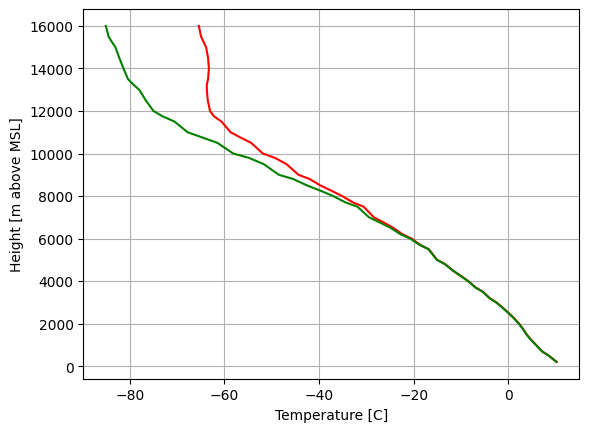

SURFACE HEIGHT (m MSL): 200.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 200.0


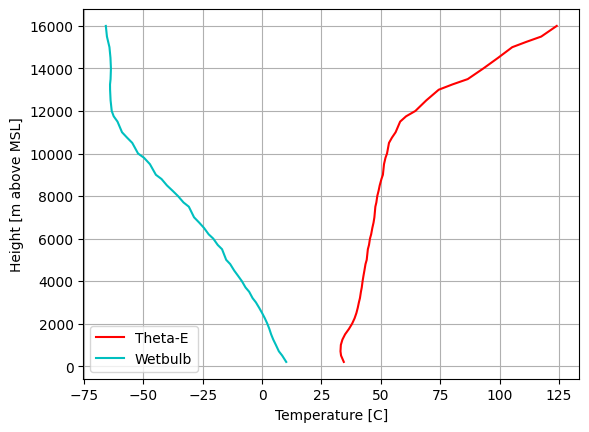

Most-Unstable CAPE: 0.0
Most-Unstable LCL: 2987.24
Most-Unstable LFC: --
Most-Unstable EL: 2987.24
Most-Unstable LI: 2.29
670-850 mb Lapse Rate: 4.81
850-950 mb Lapse Rate: 4.69
Maximum Lapse Rate: 6.44
MWPI: 0.98
T Totals: 44.03
K-index: 25.67
TEI: 9.67
MWPI WGP (kt): 35.43


/data/home004/ken.pryor/.conda/envs/devel/lib/python3.9/site-packages/SHARPpy-0+unknown-py3.9.egg/sharppy/sharptab/params.py:2275: RuntimeWarning: divide by zero encountered in double_scalars
  pcl.brn = pcl.bplus / pcl.brnshear


In [4]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('NUCAPS_NOAA21_1227_1323_MW_ret.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = mupcl.lfchght
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 950, 850, pres=True),2))
print("850-950 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)
mwp = round(params.mwpi(prof),2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
t_tot = str(round(params.t_totals(prof),2))
print("T Totals:", t_tot)
k_idx = str(round(params.k_index(prof),2))
print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
WGP = (0.35435365777 * (mwp**2)) + (1.2959855*mwp) + 33.8176788
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

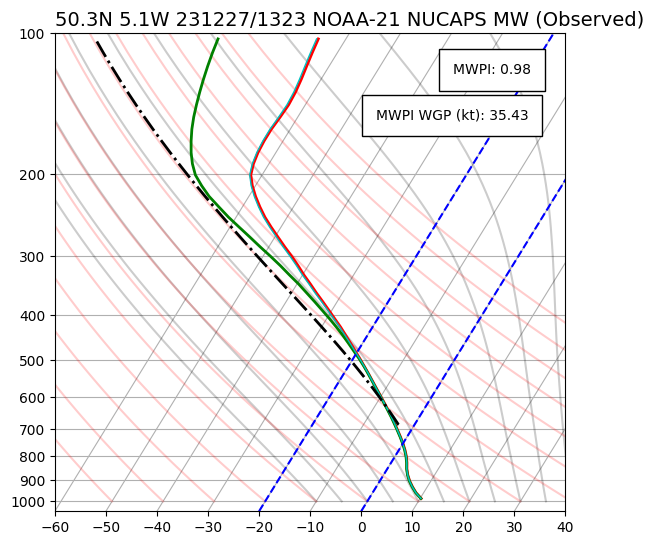

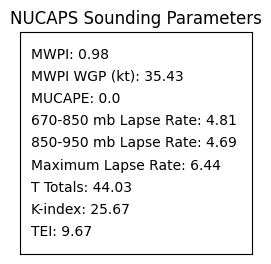

In [5]:
# Create a new figure. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('50.3N 5.1W 231227/1323 NOAA-21 NUCAPS MW (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('skewt_noaa21_231227_1323_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('NUCAPS Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 10])
ax.text(0.5, 9, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 8, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 7, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 6, r'670-850 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 5, r'850-950 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 4, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 3, r'T Totals: '+t_tot, size=10, ha='left', va='center')
ax.text(0.5, 2, r'K-index: '+k_idx, size=10, ha='left', va='center')
ax.text(0.5, 1, r'TEI: '+te_idx, size=10, ha='left', va='center')
#ax.text(2, 6, r'an equation: $E=mc^2$', fontsize=15)
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('skewt_params_noaa21_231227_1323_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

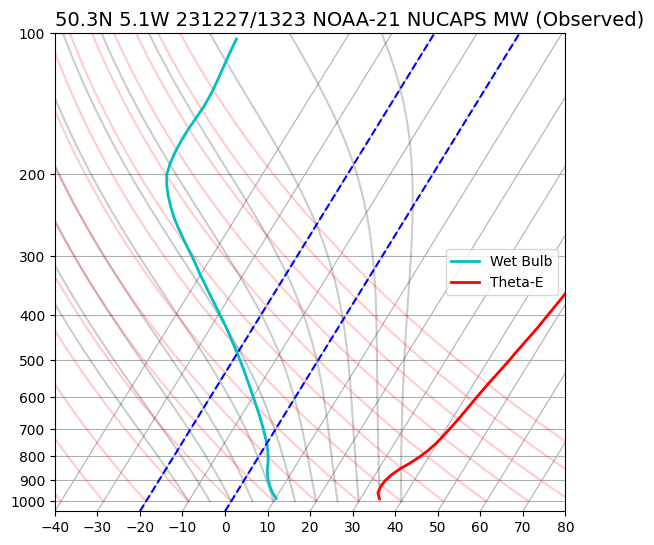

In [6]:
# Create a new figure. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('50.3N 5.1W 231227/1323 NOAA-21 NUCAPS MW (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,80)
xticks = np.arange(-40, 81, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.savefig('skewt_wbte_noaa21_231227_1323_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.legend()
plt.show()

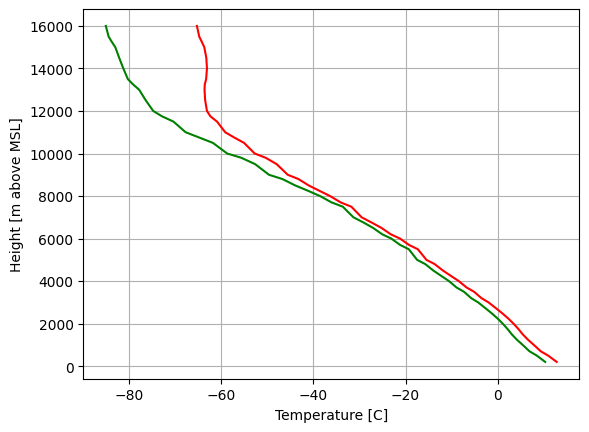

SURFACE HEIGHT (m MSL): 200.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 200.0


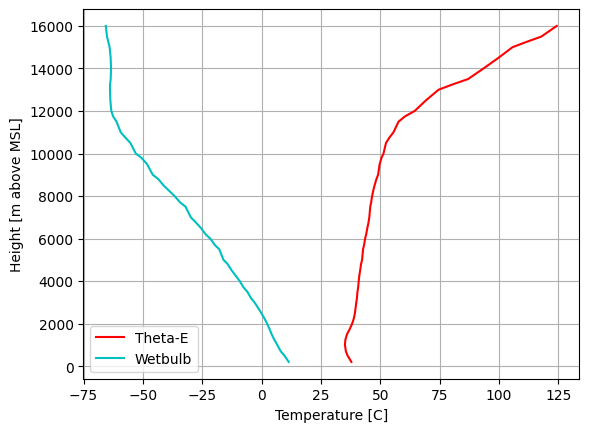

Most-Unstable CAPE: 0.0
Most-Unstable LCL: 3284.14
Most-Unstable LFC: --
Most-Unstable EL: 3284.14
Most-Unstable LI: 2.27
670-850 mb Lapse Rate: 5.5
850-950 mb Lapse Rate: 5.59
Maximum Lapse Rate: 6.84
MWPI: 1.13
T Totals: 46.05
K-index: 24.92
TEI: 6.04
MWPI WGP (kt): 35.73


In [7]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('NUCAPS_NOAA20_1227_1300_MW_ret.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = mupcl.lfchght
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 950, 850, pres=True),2))
print("850-950 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)
mwp = round(params.mwpi(prof),2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
t_tot = str(round(params.t_totals(prof),2))
print("T Totals:", t_tot)
k_idx = str(round(params.k_index(prof),2))
print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
WGP = (0.35435365777 * (mwp**2)) + (1.2959855*mwp) + 33.8176788
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

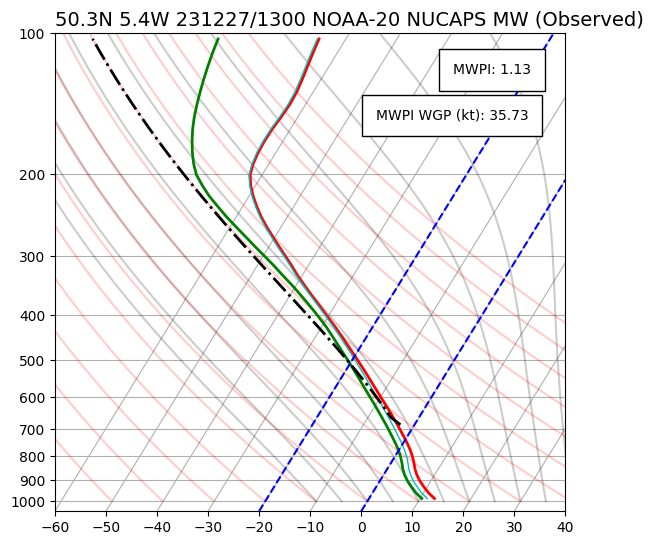

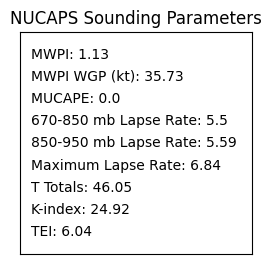

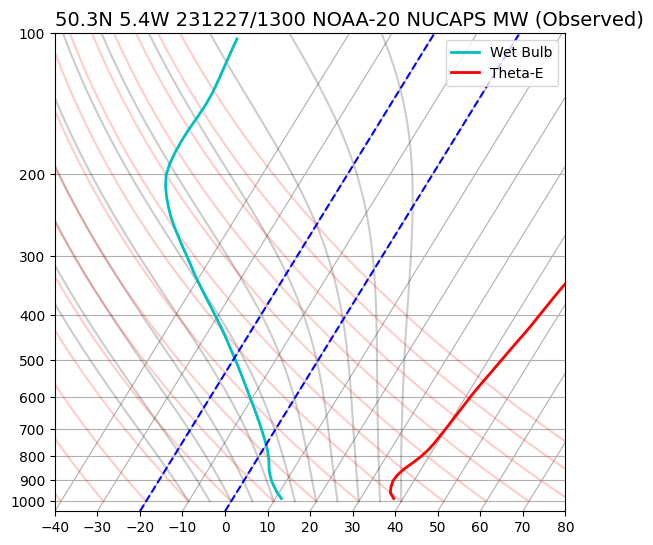

In [8]:
# Create a new figure. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('50.3N 5.4W 231227/1300 NOAA-20 NUCAPS MW (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('skewt_noaa20_231227_1300_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('NUCAPS Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 10])
ax.text(0.5, 9, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 8, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 7, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 6, r'670-850 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 5, r'850-950 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 4, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 3, r'T Totals: '+t_tot, size=10, ha='left', va='center')
ax.text(0.5, 2, r'K-index: '+k_idx, size=10, ha='left', va='center')
ax.text(0.5, 1, r'TEI: '+te_idx, size=10, ha='left', va='center')
#ax.text(2, 6, r'an equation: $E=mc^2$', fontsize=15)
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('skewt_params_noaa20_231227_1300_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

# Create a new figure. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('50.3N 5.4W 231227/1300 NOAA-20 NUCAPS MW (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,80)
xticks = np.arange(-40, 81, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
plt.savefig('skewt_wbte_noaa20_231227_1300_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.legend()
plt.show()

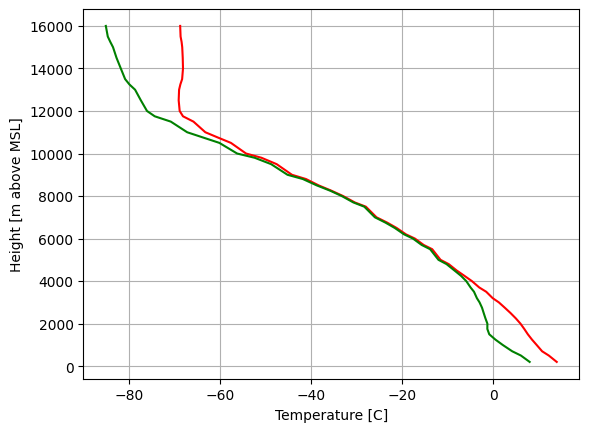

SURFACE HEIGHT (m MSL): 200.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 200.0


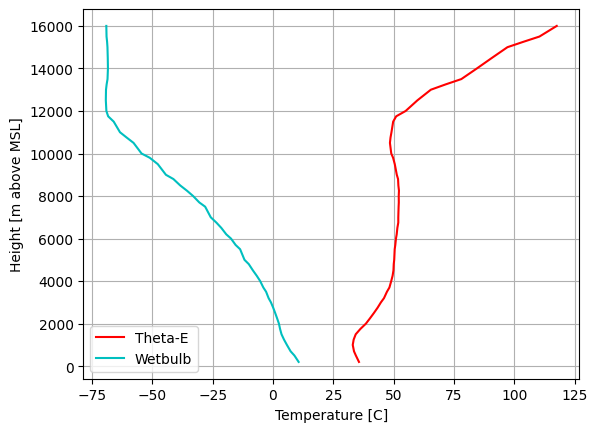

Most-Unstable CAPE: 0.0
Most-Unstable LCL: 3409.34
Most-Unstable LFC: --
Most-Unstable EL: 3409.34
Most-Unstable LI: 2.84
670-850 mb Lapse Rate: 4.59
850-950 mb Lapse Rate: 4.71
Maximum Lapse Rate: 6.76
MWPI: 0.94
T Totals: 36.49
K-index: 17.47
TEI: 16.51
MWPI WGP (kt): 35.35


In [9]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

spc_file = open('NUCAPS_METC_1227_2211_MW_ret.txt', 'r').read()

import numpy as np
from io import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.

        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx[0] : finish_idx[0]][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print("SURFACE HEIGHT (m MSL):",msl_hght)
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print("SURFACE HEIGHT (m AGL):", agl_hght)
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print("SURFACE HEIGHT (m MSL):",msl_hght)

plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

def lapse_rate(prof, lower, upper, pres=True):
    '''
        Calculates the lapse rate (C/km) from a profile object

        Parameters
        ----------
        prof : profile object
            Profile Object
        lower : number
            Lower Bound of lapse rate (mb or m AGL)
        upper : number
            Upper Bound of lapse rate (mb or m AGL)
        pres : bool (optional; default = True)
            Flag to determine if lower/upper are pressure [True]
            or height [False]

        Returns
        -------
        lapse rate (C/km) : number
        '''
    if pres:
        if (prof.pres[-1] > upper): return ma.masked
        p1 = lower
        p2 = upper
        z1 = interp.hght(prof, lower)
        z2 = interp.hght(prof, upper)
    else:
        z1 = interp.to_msl(prof, lower)
        z2 = interp.to_msl(prof, upper)
        p1 = interp.pres(prof, z1)
        p2 = interp.pres(prof, z2)
    tv1 = interp.vtmp(prof, p1)
    tv2 = interp.vtmp(prof, p2)
    return (tv2 - tv1) / (z2 - z1) * -1000.

def max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000):
    '''
        Calculates the maximum lapse rate (C/km) between a layer at a specified interval

        Parameters
        ----------
        prof: profile object
            Profile object
        lower : number
            Lower bound in height (m)
        upper : number
            Upper bound in height (m)
        interval : number
            Interval to assess the lapse rate at (m)
        depth : number
            Depth of the layer to assess the lapse rate over (m)

        Returns
        -------
        max lapse rate (C/km) : float
        lower pressure of max lapse rate (mb) : number
        upper pressure of max lapse rate (mb) : number
    '''

    bottom_levels = interp.to_msl(prof, np.arange(lower, upper-depth+interval, interval))
    top_levels = interp.to_msl(prof, np.arange(lower+depth, upper+interval, interval))
    bottom_pres = interp.pres(prof, bottom_levels)
    top_pres = interp.pres(prof, top_levels)
    all_lapse_rates = (interp.vtmp(prof, top_pres) - interp.vtmp(prof, bottom_pres)) * -1000.
    max_lapse_rate_idx = np.ma.argmax(all_lapse_rates)
    return all_lapse_rates[max_lapse_rate_idx]/depth, bottom_pres[max_lapse_rate_idx], top_pres[max_lapse_rate_idx]

sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
mucape = str(round(mupcl.bplus,2))
print("Most-Unstable CAPE:", mucape) # J/kg
lcl = round(mupcl.lclhght,2)
lfc = mupcl.lfchght
el = round(mupcl.elhght,2)
li = str(round(mupcl.li5,2))
print("Most-Unstable LCL:", lcl) # meters AGL
print("Most-Unstable LFC:", lfc) # meters AGL
print("Most-Unstable EL:", el) # meters AGL
print("Most-Unstable LI:", li) # C
lr_hi = str(round(lapse_rate(prof, 850, 670, pres=True),2))
print("670-850 mb Lapse Rate:", lr_hi)
lr_lo = str(round(lapse_rate(prof, 950, 850, pres=True),2))
print("850-950 mb Lapse Rate:", lr_lo)
lapse_rate_max, bottom_pres, top_pres = max_lapse_rate(prof, lower=2000, upper=6000, interval=250, depth=2000)
lr_max = str(round(lapse_rate_max,2))
print("Maximum Lapse Rate:", lr_max)
mwp = round(params.mwpi(prof),2)
mwp_str = str(mwp)
print("MWPI:", mwp_str) 
t_tot = str(round(params.t_totals(prof),2))
print("T Totals:", t_tot)
k_idx = str(round(params.k_index(prof),2))
print("K-index:", k_idx)
te_idx = str(round(params.tei(prof),2))
print("TEI:", te_idx)
WGP = (0.35435365777 * (mwp**2)) + (1.2959855*mwp) + 33.8176788
mwpi_gp = str(round(WGP,2))
print("MWPI WGP (kt):", mwpi_gp)

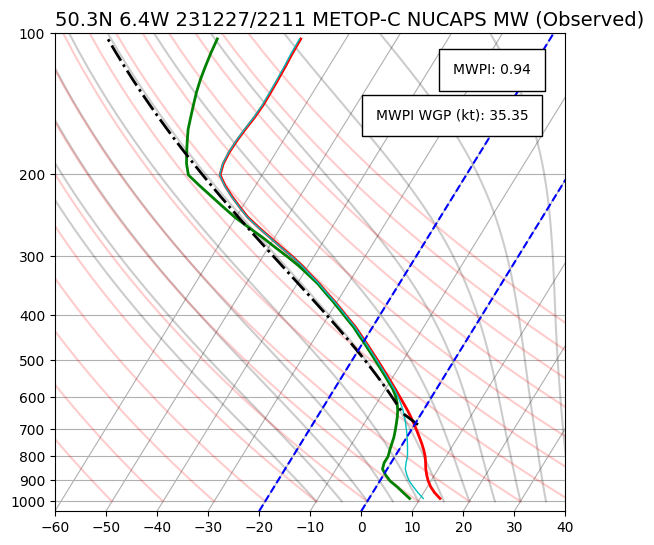

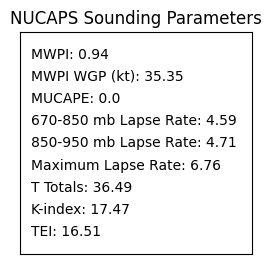

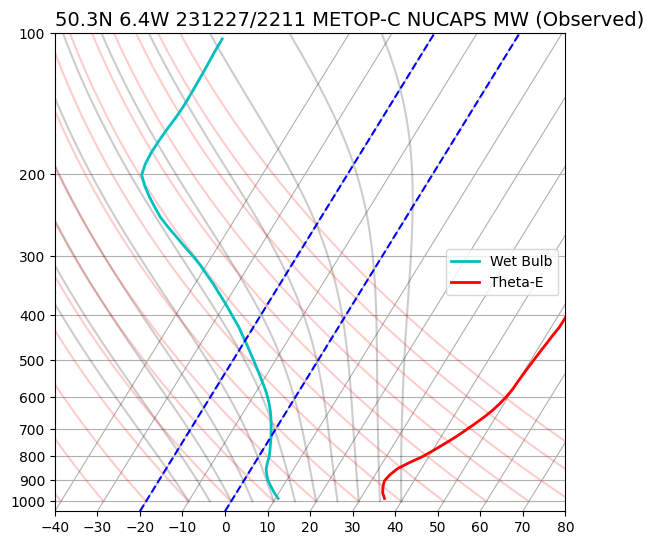

In [10]:
# Create a new figure. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('50.3N 6.4W 231227/2211 METOP-C NUCAPS MW (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)
ax.semilogy(prof.wetbulb, prof.pres, 'c-', lw=1)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-60,40)
xticks = np.arange(-60, 41, 10)
ax.set_xticks(xticks)

ax.text(-20, 120, r'MWPI: '+mwp_str, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
ax.text(-15, 150, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='right', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10})
# Show the plot to the user.
plt.savefig('skewt_metc_231227_2211_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
ax.set_title('NUCAPS Sounding Parameters')
#ax.set_xlabel('xlabel')
#ax.set_ylabel('ylabel')

# Set both x- and y-axis limits to [0, 10] instead of default [0, 1]
ax.axis([0, 10, 0, 10])
ax.text(0.5, 9, r'MWPI: '+mwp_str, size=10, ha='left', va='center')
ax.text(0.5, 8, r'MWPI WGP (kt): '+mwpi_gp, size=10, ha='left', va='center')
ax.text(0.5, 7, r'MUCAPE: '+mucape, size=10, ha='left', va='center')
ax.text(0.5, 6, r'670-850 mb Lapse Rate: '+lr_hi, size=10, ha='left', va='center')
ax.text(0.5, 5, r'850-950 mb Lapse Rate: '+lr_lo, size=10, ha='left', va='center')
ax.text(0.5, 4, r'Maximum Lapse Rate: '+lr_max, size=10, ha='left', va='center')
ax.text(0.5, 3, r'T Totals: '+t_tot, size=10, ha='left', va='center')
ax.text(0.5, 2, r'K-index: '+k_idx, size=10, ha='left', va='center')
ax.text(0.5, 1, r'TEI: '+te_idx, size=10, ha='left', va='center')
#ax.text(2, 6, r'an equation: $E=mc^2$', fontsize=15)
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('skewt_params_metc_231227_2211_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()

# Create a new figure. The dimensions here give a good aspect ratio
import sharppy.plot.skew as skew
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title('50.3N 6.4W 231227/2211 METOP-C NUCAPS MW (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.wetbulb, prof.pres, 'c', lw=2, label='Wet Bulb')
ax.semilogy(thermo.ktoc(prof.thetae), prof.pres, 'r', lw=2, label='Theta-E')

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-40,80)
xticks = np.arange(-40, 81, 10)
ax.set_xticks(xticks)

# Show the plot to the user.
# plt.savefig('skewt.png', bbox_inches='tight') # saves the plot to the disk.
plt.legend()
plt.savefig('skewt_wbte_metc_231227_2211_mw.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()